<a href="https://colab.research.google.com/github/harshjoshi23/AI1_Task1/blob/main/Done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define paths to dataset folders
base_path = '/content/drive/My Drive/CamVid_Actual'
train_images = os.path.join(base_path, 'train')
train_labels = os.path.join(base_path, 'train_labels')
test_images = os.path.join(base_path, 'test')
test_labels = os.path.join(base_path, 'test_labels')
val_images = os.path.join(base_path, 'val')
val_labels = os.path.join(base_path, 'val_labels')

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Class dictionary path
class_dict_path = os.path.join(base_path, "class_dict.csv")

class_dict = pd.read_csv(class_dict_path)
print(class_dict.head())


        name    r    g    b
0     Animal   64  128   64
1    Archway  192    0  128
2  Bicyclist    0  128  192
3     Bridge    0  128   64
4   Building  128    0    0


In [5]:

# Color mapping from CSV
color_to_class = {tuple(row[['r', 'g', 'b']].values): idx for idx, row in class_dict.iterrows()}
class_to_color = {idx: tuple(row[['r', 'g', 'b']].values) for idx, row in class_dict.iterrows()}

# Dataset paths
train_images_path = sorted([os.path.join(base_path, "train", x) for x in os.listdir(os.path.join(base_path, "train"))])
train_labels_path = sorted([os.path.join(base_path, "train_labels", x) for x in os.listdir(os.path.join(base_path, "train_labels"))])
val_images_path = sorted([os.path.join(base_path, "val", x) for x in os.listdir(os.path.join(base_path, "val"))])
val_labels_path = sorted([os.path.join(base_path, "val_labels", x) for x in os.listdir(os.path.join(base_path, "val_labels"))])

# Example transformation and dataset class
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [6]:
class CamVidDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None, label_transform=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.transform = transform
        self.label_transform = label_transform  # Separate transform for labels

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        image = Image.open(self.images_path[idx]).convert("RGB")
        label = Image.open(self.labels_path[idx])

        if self.transform:
            image = self.transform(image)

        if self.label_transform:
            label = self.label_transform(label)  # Applyoing the label-specific transformations

        # Converting label to class indices using color mapping
        label = np.array(label, dtype=np.int32)  # Ensure using int32 for label indexing
        mask = np.zeros((label.shape[0], label.shape[1]), dtype=np.int64)
        for rgb, class_id in color_to_class.items():
            match = (label == np.array(rgb, dtype=np.int32)).all(axis=-1)
            mask[match] = class_id

        label = torch.from_numpy(mask)
        return image, label

# transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

label_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST)  # Resize labels to match image size
])

train_dataset = CamVidDataset(train_images_path, train_labels_path, transform, label_transform)
val_dataset = CamVidDataset(val_images_path, val_labels_path, transform, label_transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)


Image batch shape: torch.Size([2, 3, 256, 256])
Label batch shape: torch.Size([2, 256, 256])


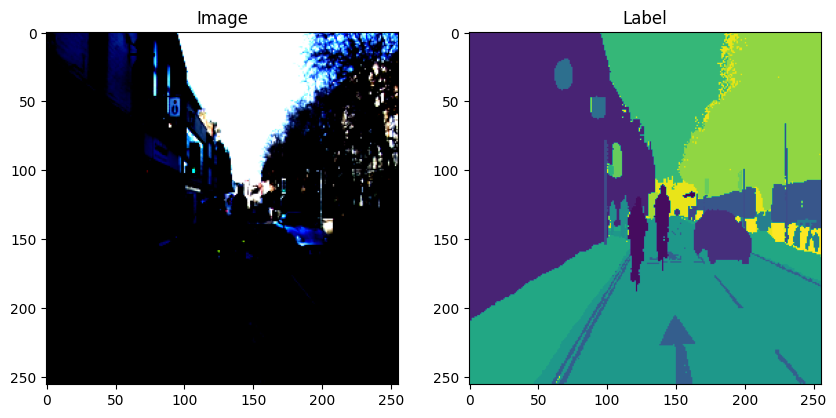

In [7]:
# Quick check
for images, labels in train_loader:
    print(f"Image batch shape: {images.size()}")
    print(f"Label batch shape: {labels.size()}")
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(images[0].permute(1, 2, 0).numpy())
    plt.title("Image")
    plt.subplot(122)
    plt.imshow(labels[0].numpy())
    plt.title("Label")
    plt.show()
    break

In [8]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)
        self.down4 = DoubleConv(512, 512)
        self.up1 = DoubleConv(1024, 256)
        self.up2 = DoubleConv(512, 128)
        self.up3 = DoubleConv(256, 64)
        self.up4 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(torch.cat([x4, x5], dim=1))
        x = self.up2(torch.cat([x3, x], dim=1))
        x = self.up3(torch.cat([x2, x], dim=1))
        x = self.up4(torch.cat([x1, x], dim=1))
        logits = self.outc(x)
        return logits

# Model initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=len(class_dict)).to(device)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [10]:
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, early_stopping_patience=10):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using device: {device}')  # Check which device is being used
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == masks).sum().item()
            total_train += masks.numel()

        train_accuracy = 100 * correct_train / total_train

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        iou_per_class = []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                correct_val += (preds == masks).sum().item()
                total_val += masks.numel()

                for class_id in range(len(class_dict)):  # Make sure class_dict is defined
                    intersection = ((preds == class_id) & (masks == class_id)).float().sum()
                    union = ((preds == class_id) | (masks == class_id)).float().sum()
                    if union > 0:
                        iou_per_class.append(intersection / union)

        val_accuracy = 100 * correct_val / total_val
        average_iou = sum(iou_per_class) / len(iou_per_class) if iou_per_class else 0
        val_loss /= len(val_loader)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.3f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_accuracy:.2f}%, Average IoU: {average_iou:.4f}')

        # Early stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            print('Early stopping!')
            break

        if val_accuracy >= 85:
            print('Reached 85% accuracy, stopping early!')
            break

#Calling train_model reducing epoches to 25 as free collab runs out of memeory
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)


Using device: cuda
Epoch 1/25, Train Loss: 1.484, Train Acc: 59.96%, Val Loss: 1.319, Val Acc: 61.60%, Average IoU: 0.1366
Epoch 2/25, Train Loss: 1.128, Train Acc: 65.77%, Val Loss: 1.188, Val Acc: 58.68%, Average IoU: 0.1297
Epoch 3/25, Train Loss: 1.052, Train Acc: 68.11%, Val Loss: 1.025, Val Acc: 68.15%, Average IoU: 0.1797
Epoch 4/25, Train Loss: 0.978, Train Acc: 70.48%, Val Loss: 1.004, Val Acc: 70.36%, Average IoU: 0.1826
Epoch 5/25, Train Loss: 0.923, Train Acc: 72.06%, Val Loss: 0.996, Val Acc: 71.08%, Average IoU: 0.1877
Epoch 6/25, Train Loss: 0.889, Train Acc: 73.10%, Val Loss: 0.863, Val Acc: 74.66%, Average IoU: 0.2129
Epoch 7/25, Train Loss: 0.833, Train Acc: 74.90%, Val Loss: 0.894, Val Acc: 73.26%, Average IoU: 0.2081
Epoch 8/25, Train Loss: 0.817, Train Acc: 75.57%, Val Loss: 0.808, Val Acc: 76.22%, Average IoU: 0.2168
Epoch 9/25, Train Loss: 0.779, Train Acc: 76.61%, Val Loss: 0.779, Val Acc: 76.76%, Average IoU: 0.2248
Epoch 10/25, Train Loss: 0.761, Train Acc: 77

In [ ]:
# look to add dropuut in furture

In [10]:
# '''Data Augmentation code : '''

# from torchvision.transforms import RandomHorizontalFlip, RandomRotation

# train_transforms = transforms.Compose([
#     transforms.Resize((256, 256)),
#     RandomHorizontalFlip(),
#     RandomRotation(degrees=10),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# train_dataset = CamVidDataset(train_images_path, train_labels_path, train_transforms, label_transform)


In [15]:
test_images_path = sorted([os.path.join(base_path, "test", x) for x in os.listdir(os.path.join(base_path, "test"))])
test_labels_path = sorted([os.path.join(base_path, "test_labels", x) for x in os.listdir(os.path.join(base_path, "test_labels"))])

test_dataset = CamVidDataset(test_images_path, test_labels_path, transform, label_transform)

test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


In [19]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    iou_per_class = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, masks).item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == masks).sum().item()
            total += masks.numel()

            # Calculate IoU for each class
            for class_id in range(len(class_dict)):
                intersection = ((preds == class_id) & (masks == class_id)).float().sum()
                union = ((preds == class_id) | (masks == class_id)).float().sum()
                if union > 0:
                    iou_per_class.append(intersection / union)

    average_iou = sum(iou_per_class) / len(iou_per_class) if iou_per_class else 0
    test_accuracy = 100 * correct / total
    test_loss /= len(test_loader)

    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2f}%, Average IoU: {average_iou:.4f}')

evaluate_model(model, test_loader, criterion)


Test Loss: 1.158, Test Accuracy: 69.74%, Average IoU: 0.2225


In [17]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    iou_per_class = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, masks).item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == masks).sum().item()
            total += masks.numel()

            # Calculate IoU for each class
            for class_id in range(len(class_dict)):
                intersection = ((preds == class_id) & (masks == class_id)).float().sum()
                union = ((preds == class_id) | (masks == class_id)).float().sum()
                if union > 0:
                    iou_per_class.append(intersection / union)

    average_iou = sum(iou_per_class) / len(iou_per_class) if iou_per_class else 0
    test_accuracy = 100 * correct / total
    test_loss /= len(test_loader)

    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2f}%, Average IoU: {average_iou:.4f}')

# Call the evaluation function with the defined test_loader
evaluate_model(model, test_loader, criterion)


Test Loss: 1.158, Test Accuracy: 69.74%, Average IoU: 0.2225


## Nicely labeled examples

what was the issue prev:
subsequent images from the loader do not meet the condition if not torch.equal(preds[idx], true_masks[idx]), which is used to filter examples where the prediction and the true mask are different

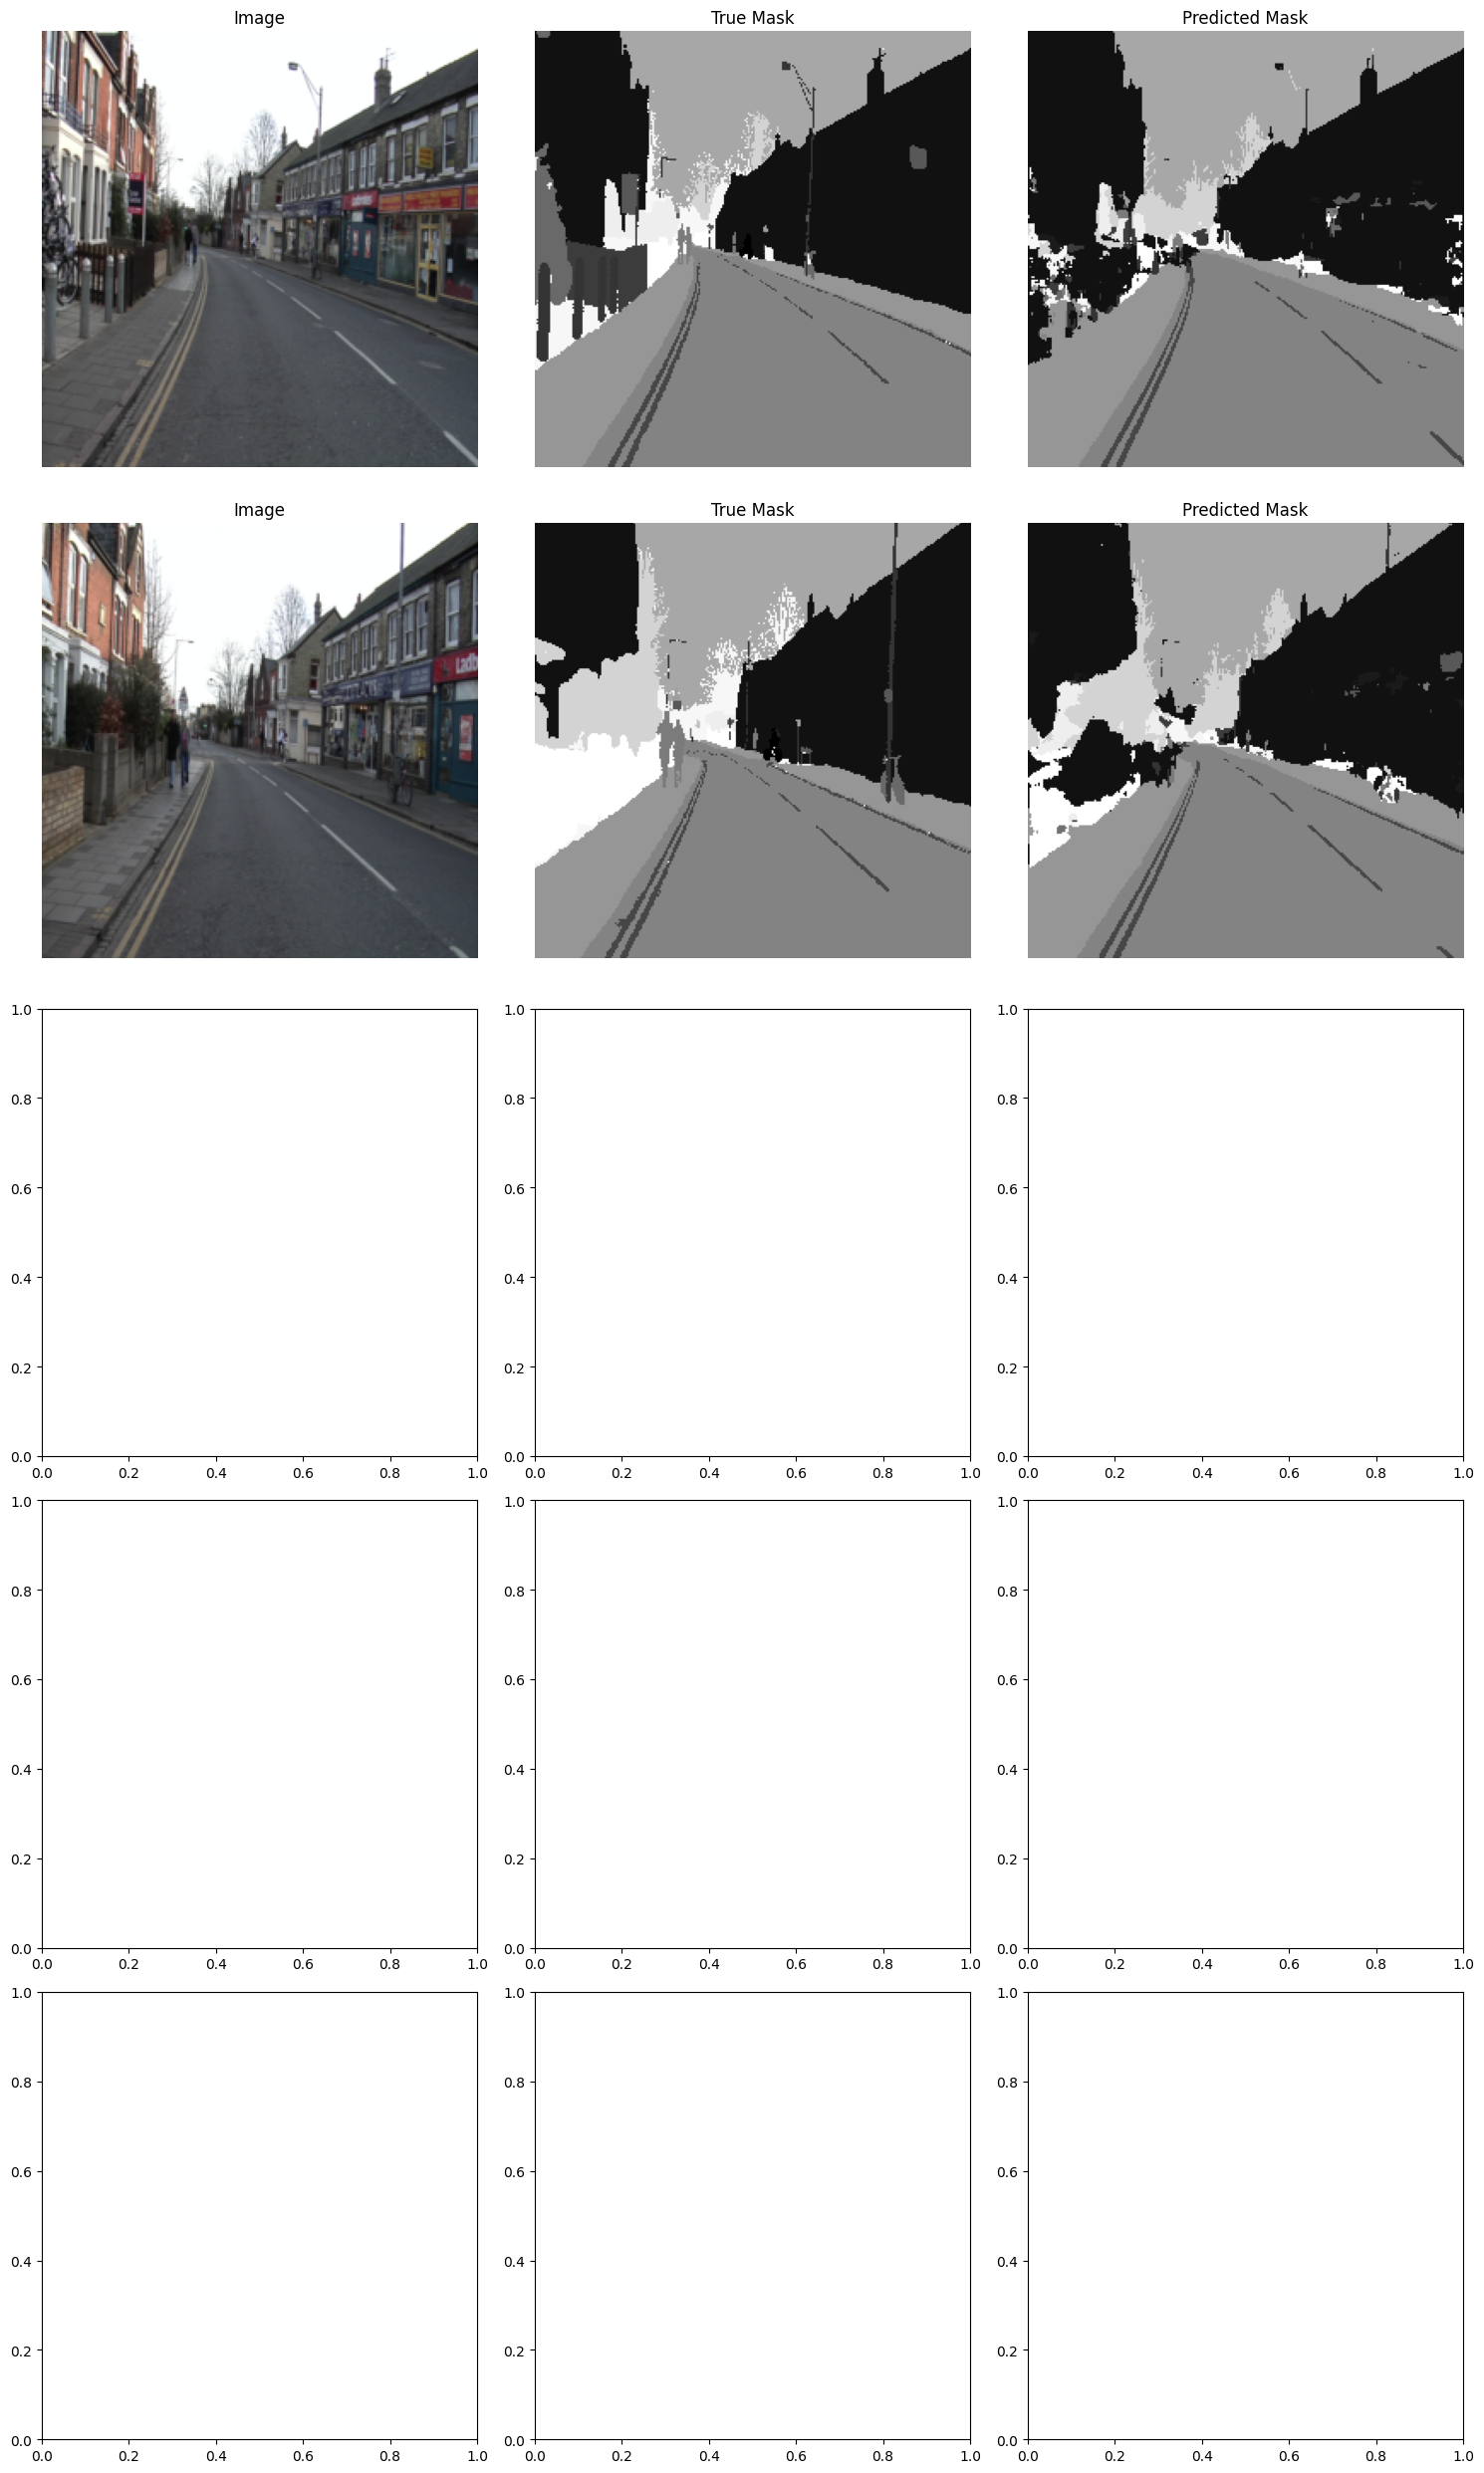

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_error_examples(model, loader, device, num_examples=5):
    model.eval()
    fig, axs = plt.subplots(num_examples, 3, figsize=(15, 5 * num_examples))  # 3 columns for image, true mask, predicted mask

    # Define the mean and std used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    def unnormalize(image):
        image = image.permute(1, 2, 0).cpu().numpy()  # Change from CxHxW to HxWxC for imshow
        image = std * image + mean  # Reverse the normalization
        return np.clip(image, 0, 1)  # Ensure the pixel values are within [0, 1]

    with torch.no_grad():
        for images, true_masks in loader:
            images, true_masks = images.to(device), true_masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            count = 0
            for idx in range(images.shape[0]):
                if count >= num_examples:
                    break
                if not torch.equal(preds[idx], true_masks[idx]):
                    # Unnormalize and display the image
                    axs[count, 0].imshow(unnormalize(images[idx]))
                    axs[count, 0].set_title('Image')
                    axs[count, 0].axis('off')

                    # Display the true mask
                    axs[count, 1].imshow(true_masks[idx].cpu().numpy(), cmap='gray')
                    axs[count, 1].set_title('True Mask')
                    axs[count, 1].axis('off')

                    # Display the predicted mask
                    axs[count, 2].imshow(preds[idx].cpu().numpy(), cmap='gray')
                    axs[count, 2].set_title('Predicted Mask')
                    axs[count, 2].axis('off')

                    count += 1
                else:
                    print(f"Skipping example {idx} - prediction matches the true mask.")

            if count >= num_examples:
                break

    plt.tight_layout()
    plt.show()

# Example usage:
plot_error_examples(model, val_loader, device)


## Looking For Mis preds

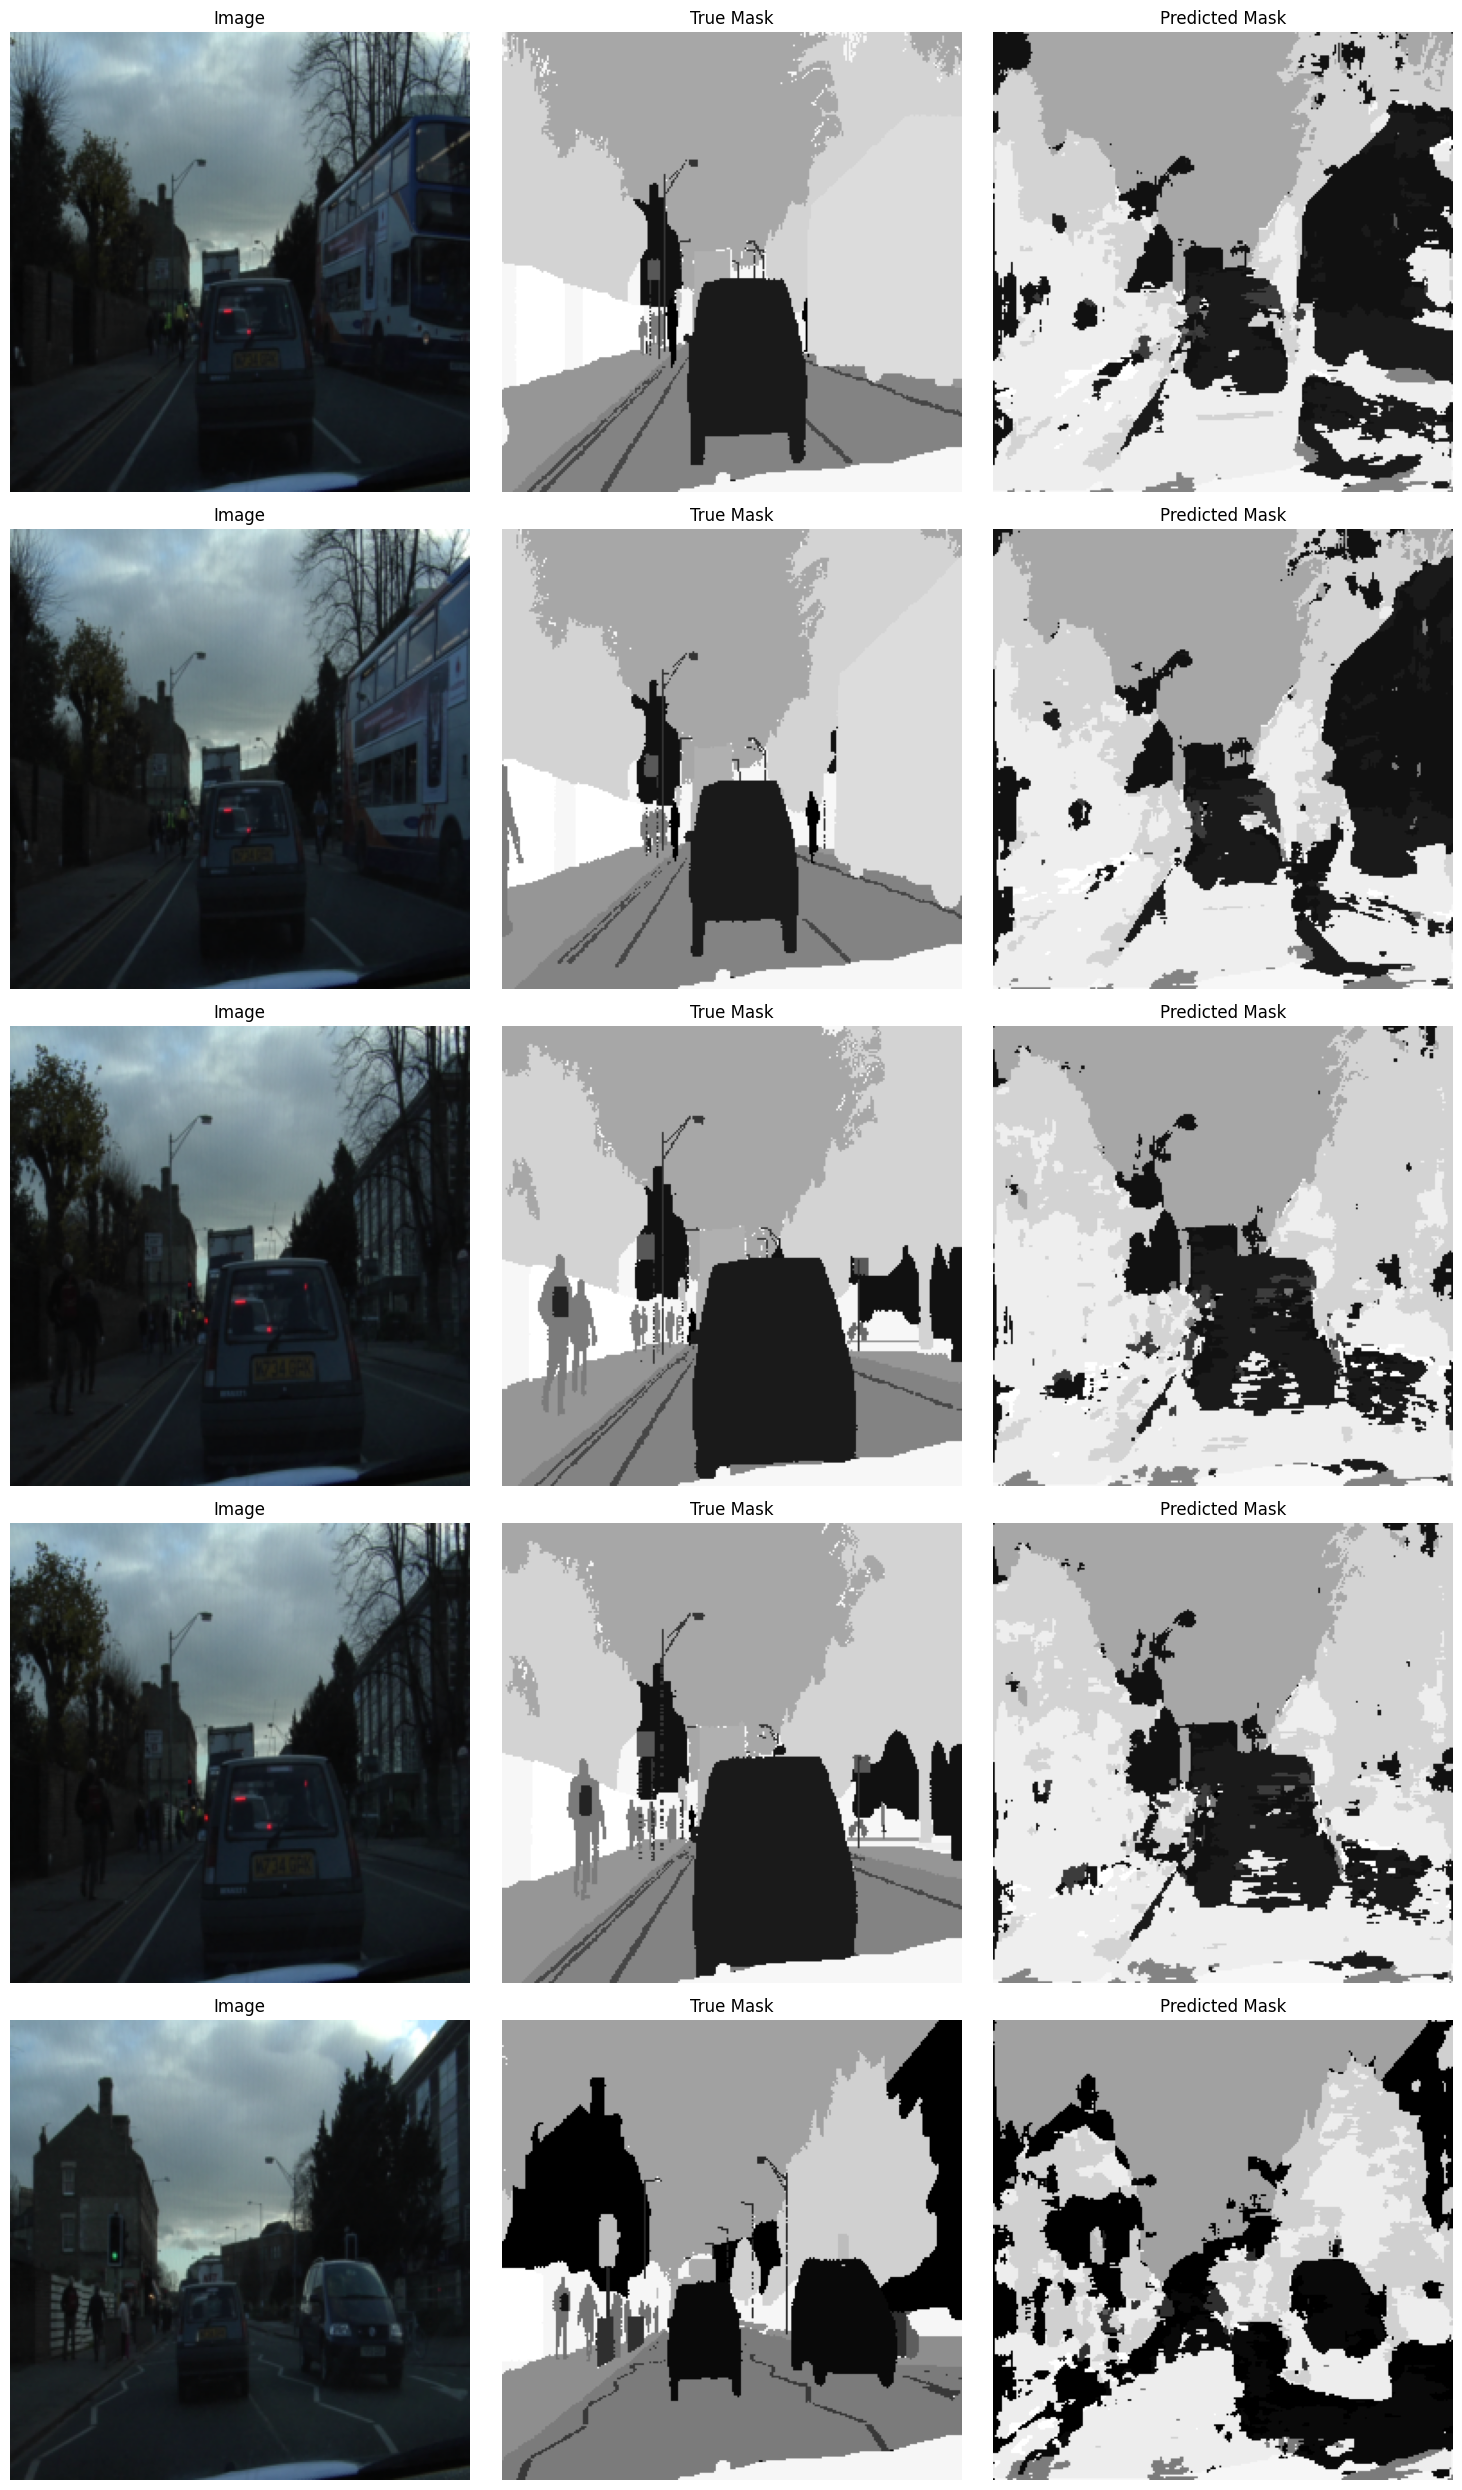

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_error_examples(model, loader, device, max_examples=5):
    model.eval()
    examples = []

    with torch.no_grad():
        for images, true_masks in loader:
            if len(examples) >= max_examples:
                break
            images, true_masks = images.to(device), true_masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for img, true_mask, pred in zip(images, true_masks, preds):
                if len(examples) >= max_examples:
                    break
                if not torch.equal(pred, true_mask):
                    examples.append((img, true_mask, pred))

    if not examples:
        print("No mispredicted examples found.")
        return

    # Now plot the examples
    fig, axs = plt.subplots(len(examples), 3, figsize=(15, 5 * len(examples)))
    if len(examples) == 1:
        axs = [axs]

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for idx, (img, true_mask, pred) in enumerate(examples):
        img = img.cpu().permute(1, 2, 0).numpy()
        img = std * img + mean
        img = np.clip(img, 0, 1)

        axs[idx][0].imshow(img)
        axs[idx][0].set_title('Image')
        axs[idx][0].axis('off')

        axs[idx][1].imshow(true_mask.cpu().numpy(), cmap='gray')
        axs[idx][1].set_title('True Mask')
        axs[idx][1].axis('off')

        axs[idx][2].imshow(pred.cpu().numpy(), cmap='gray')
        axs[idx][2].set_title('Predicted Mask')
        axs[idx][2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_error_examples(model, val_loader, device)
